# ANLI Dataset Exploratory Data Analysis

This notebook provides a comprehensive exploratory data analysis of the ANLI (Adversarial Natural Language Inference) dataset from Facebook AI Research.

## Dataset Overview
ANLI is a large-scale NLI benchmark dataset collected via an iterative, adversarial human-and-model-in-the-loop procedure. The dataset consists of three rounds (R1, R2, R3) of increasing difficulty.

In [20]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Loading the Dataset

Let us load the ANLI dataset from HuggingFace's datasets library. The dataset contains three rounds of training data, each progressively more challenging.

In [21]:
from datasets import load_dataset

ds = load_dataset("facebook/anli")

## 2. Data Preparation

We'll combine the first two rounds of training data for analysis. Each round represents a different level of adversarial difficulty.

In [22]:
# Convert to pandas dataframes
train_r1 = pd.DataFrame(ds['train_r1'])
train_r2 = pd.DataFrame(ds['train_r2'])

# Combine all rounds with round identifier
train_all = pd.concat([train_r1, train_r2], keys=['R1', 'R2'])
train_all = train_all.reset_index(level=0).rename(columns={'level_0': 'round'})

# Display basic information
print(train_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62406 entries, 0 to 45459
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   round       62406 non-null  object
 1   uid         62406 non-null  object
 2   premise     62406 non-null  object
 3   hypothesis  62406 non-null  object
 4   label       62406 non-null  int64 
 5   reason      62406 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.3+ MB
None


### Dataset Structure

The dataset contains the following columns:
- **round**: Which adversarial round the example belongs to (R1, R2)
- **uid**: Unique identifier for each example
- **premise**: The premise text
- **hypothesis**: The hypothesis text
- **label**: The relationship between premise and hypothesis (0=Entailment, 1=Neutral, 2=Contradiction)
- **reason**: Explanation for the label (may be empty)

In [23]:
train_all.head()

,round,uid,premise,hypothesis,label,reason
0,R1,0fd0abfb-659e-4453-b196-c3a64d2d8267,"The Parma trolleybus system (Italian: ""Rete fi...",The trolleybus system has over 2 urban routes,0,
1,R1,7ed72ff4-40b7-4f8a-b1b9-6c612aa62c84,Alexandra Lendon Bastedo (9 March 1946 – 12 Ja...,Sharron Macready was a popular character throu...,1,
2,R1,5d2930a3-62ac-485d-94d7-4e36cbbcd7b5,Alexandra Lendon Bastedo (9 March 1946 – 12 Ja...,Bastedo didn't keep any pets because of her vi...,1,
3,R1,324db753-ddc9-4a85-a825-f09e2e5aebdd,Alexandra Lendon Bastedo (9 March 1946 – 12 Ja...,Alexandra Bastedo was named by her mother.,1,
4,R1,4874f429-da0e-406a-90c7-22240ff3ddf8,Alexandra Lendon Bastedo (9 March 1946 – 12 Ja...,Bastedo cared for all the animals that inhabit...,1,


## 3. Label Distribution Analysis

Understanding the distribution of labels is crucial for:
- Identifying class imbalance
- Understanding dataset composition
- Informing model training strategies

Samples per round:
round
R2    45460
R1    16946
Name: count, dtype: int64


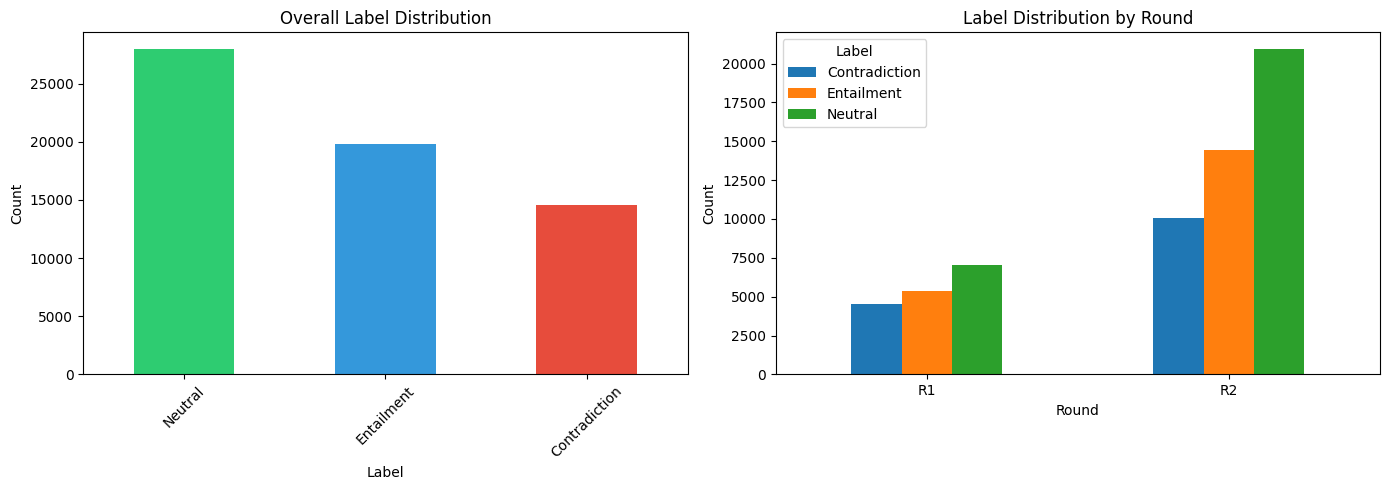

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Samples per round:")
print(train_all['round'].value_counts())

# Create label mapping
label_map = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}
train_all['label_name'] = train_all['label'].map(label_map)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
train_all['label_name'].value_counts().plot(
    kind='bar', 
    ax=axes[0], 
    color=['#2ecc71', '#3498db', '#e74c3c']
)
axes[0].set_title('Overall Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Per round distribution
pd.crosstab(train_all['round'], train_all['label_name']).plot(
    kind='bar', 
    ax=axes[1]
)
axes[1].set_title('Label Distribution by Round')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Label')

plt.tight_layout()
plt.show()

### Interpretation: Label Distribution

**Key Observations:**
1. **Class Balance**: The dataset shows relatively balanced distribution across the three classes (Entailment, Neutral, Contradiction), which is beneficial for training robust NLI models.

2. **Round Comparison**: 
   - R2 contains significantly more samples than R1, indicating increased data collection in later rounds
   - The label distribution remains consistent across rounds, suggesting systematic data collection

3. **Implications**:
   - The balanced nature reduces the need for class weighting during training
   - Models trained on this data should perform equally well across all three inference types

## 4. Text Length Analysis

Analyzing text lengths helps us understand:
- Input complexity and diversity
- Potential computational requirements
- Differences between adversarial rounds

In [25]:
# Add length columns
train_all['premise_len'] = train_all['premise'].str.len()
train_all['hypothesis_len'] = train_all['hypothesis'].str.len()
train_all['premise_words'] = train_all['premise'].str.split().str.len()
train_all['hypothesis_words'] = train_all['hypothesis'].str.split().str.len()

# Summary statistics
print("Premise Length Stats (characters):")
print(train_all.groupby('round')['premise_len'].describe())

print("\nHypothesis Length Stats (characters):")
print(train_all.groupby('round')['hypothesis_len'].describe())

Premise Length Stats (characters):
         count        mean        std    min    25%    50%    75%    max
round                                                                   
R1     16946.0  326.411247  44.052357  250.0  288.0  327.0  365.0  400.0
R2     45460.0  326.795930  43.617951  250.0  289.0  328.0  365.0  400.0

Hypothesis Length Stats (characters):
         count       mean        std   min   25%   50%   75%    max
round                                                              
R1     16946.0  63.594595  32.682601  15.0  43.0  56.0  74.0  357.0
R2     45460.0  57.131148  31.850362  15.0  38.0  50.0  66.0  393.0


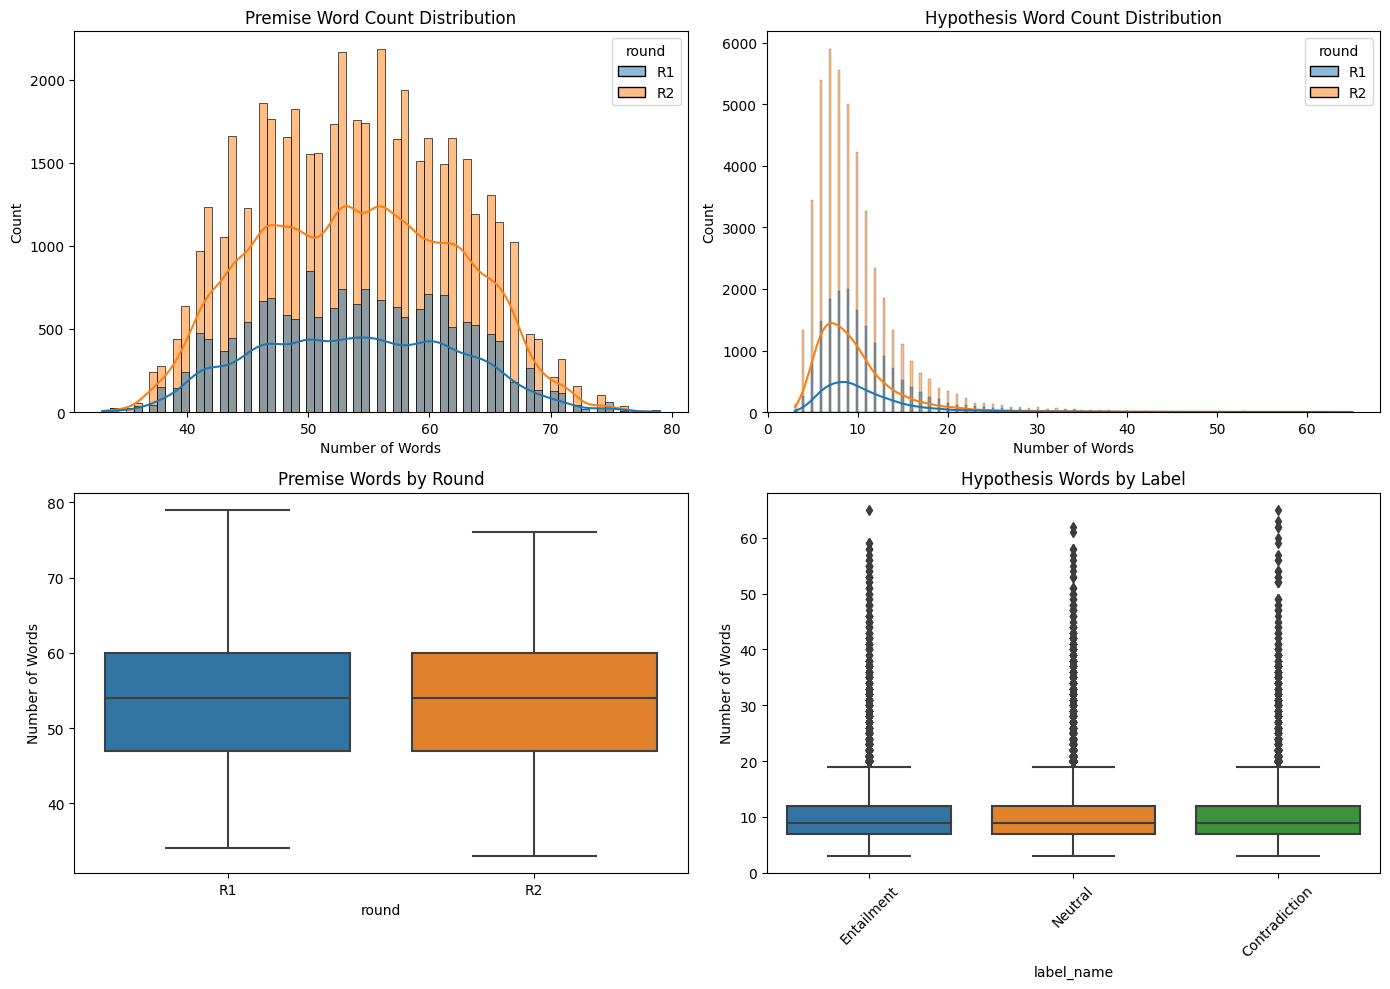

In [26]:
# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(
    data=train_all, 
    x='premise_words', 
    hue='round', 
    kde=True, 
    ax=axes[0, 0]
)
axes[0, 0].set_title('Premise Word Count Distribution')
axes[0, 0].set_xlabel('Number of Words')

sns.histplot(
    data=train_all, 
    x='hypothesis_words', 
    hue='round', 
    kde=True, 
    ax=axes[0, 1]
)
axes[0, 1].set_title('Hypothesis Word Count Distribution')
axes[0, 1].set_xlabel('Number of Words')

sns.boxplot(
    data=train_all, 
    x='round', 
    y='premise_words', 
    ax=axes[1, 0]
)
axes[1, 0].set_title('Premise Words by Round')
axes[1, 0].set_ylabel('Number of Words')

sns.boxplot(
    data=train_all, 
    x='label_name', 
    y='hypothesis_words', 
    ax=axes[1, 1]
)
axes[1, 1].set_title('Hypothesis Words by Label')
axes[1, 1].set_ylabel('Number of Words')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Interpretation: Text Length Analysis

**Premise Analysis:**
1. **Consistency Across Rounds**: Premises maintain similar length distributions across R1 and R2 (mean ~327 characters, ~60 words)
2. **Controlled Length**: The relatively tight distribution suggests premises are carefully curated to be informative yet concise
3. **Standard Deviation**: Low variance indicates consistent complexity across examples

**Hypothesis Analysis:**
1. **Shorter Than Premises**: Hypotheses are significantly shorter (mean ~50-60 characters, ~10-12 words)
2. **Round Differences**: R1 hypotheses are slightly longer than R2, possibly indicating refinement in adversarial strategy
3. **Label Variation**: Hypothesis length appears relatively consistent across different labels

**Implications for Modeling:**
- **Input Size**: Maximum sequence length should accommodate ~100 words for premises
- **Attention Mechanisms**: The length disparity between premises and hypotheses may benefit from asymmetric attention
- **Computational Efficiency**: Relatively short texts allow for efficient batch processing

## 5. Summary and Conclusions

### Dataset Characteristics:
1. **Size**: 62,406 training examples across two rounds
2. **Balance**: Well-balanced across three NLI classes
3. **Text Length**: Premises average ~60 words, hypotheses ~10-12 words
4. **Adversarial Design**: Progressive difficulty across rounds

### Approach for Model Training:
1. **No class weighting needed** due to balanced distribution
2. **Max sequence length** of 128 tokens I guess should suffice for most examples
3. **Round-specific evaluation** to assess model robustness against adversarial examples